```{contents}
```
## **Gate in LangGraph**

In LangGraph, a **Gate** is a **control-flow mechanism** that conditionally **permits or blocks execution** of downstream nodes based on the current **state**, **events**, or **external conditions**.
Gates implement **decision boundaries** in a graph, enabling **safe, adaptive, and production-grade workflows**.

---

### **1. Intuition**

A Gate behaves like a **checkpoint or control valve**:

> **If condition satisfied → allow flow**
> **Else → stop, wait, redirect, or escalate**

Without gates, a graph is a blind pipeline.
With gates, it becomes a **policy-driven control system**.

---

### **2. Why Gates Matter**

| Problem                | How Gate Solves       |
| ---------------------- | --------------------- |
| Prevent unsafe actions | Blocks execution      |
| Human approval         | Waits for consent     |
| Budget control         | Stops expensive calls |
| Quality assurance      | Forces validation     |
| Error handling         | Routes to recovery    |
| Compliance             | Enforces policy       |

---

### **3. How Gates Are Implemented in LangGraph**

LangGraph does not expose a `Gate` class explicitly.
Instead, **gates are implemented using conditional edges and router functions**.

```
Node → [ Gate Condition ] → Allowed Path
                 ↓
             Blocked Path
```

---

### **4. Gate Implementation Pattern**

### **State**

```python
class State(TypedDict):
    approved: bool
    risk: float
    output: str
```

### **Gate Function**

```python
def safety_gate(state):
    if state["approved"] and state["risk"] < 0.3:
        return "allow"
    return "block"
```

### **Graph Wiring**

```python
builder.add_conditional_edges(
    "review",
    safety_gate,
    {
        "allow": "execute",
        "block": "human_review"
    }
)
```

---

### **5. Execution Flow**

```
Review Node
     |
 [ Gate: safety_gate ]
     |
  ┌───┴─────────┐
Allow         Block
  |             |
Execute     Human Review
```

---

### **6. Common Gate Variants**

| Gate Type       | Purpose                 |
| --------------- | ----------------------- |
| Safety Gate     | Prevent harmful actions |
| Approval Gate   | Require human consent   |
| Quality Gate    | Validate output         |
| Budget Gate     | Enforce cost limits     |
| Timeout Gate    | Stop long execution     |
| Risk Gate       | Risk-based routing      |
| Policy Gate     | Enforce business rules  |
| Confidence Gate | Require certainty       |
| Compliance Gate | Regulatory enforcement  |

---

### **7. Production Example: Human Approval Gate**

```python
def approval_gate(state):
    return "approved" if state["approved"] else "pending"

builder.add_conditional_edges("draft", approval_gate, {
    "approved": "publish",
    "pending": "request_human"
})
```

---

### **8. Advanced Gate: Budget Control**

```python
def cost_gate(state):
    if state["tokens_used"] > 10_000:
        return "halt"
    return "continue"
```

---

### **9. Failure Handling with Gates**

Gates are often combined with **retry, fallback, and compensation nodes**:

```
Execute → Gate → Success
          ↓
       Retry → Fallback → Alert
```

---

### **10. Why Gates Enable Enterprise Systems**

| Without Gates  | With Gates        |
| -------------- | ----------------- |
| Unsafe         | Safe              |
| No compliance  | Policy-driven     |
| Unbounded cost | Cost-controlled   |
| No oversight   | Human-in-the-loop |
| Hard to debug  | Traceable         |

---

### **11. Mental Model**

Think of gates as **policy checkpoints** in a distributed system:

> **Data → Validation → Decision → Controlled Execution**

They convert LangGraph from a workflow engine into a **governed execution platform**.


### Demonstration

In [1]:
# One-cell, complete demonstration of a Gate in LangGraph

from typing import TypedDict
from langgraph.graph import StateGraph, END

# -------------------------------
# 1. Define shared state
# -------------------------------
class State(TypedDict):
    draft: str
    approved: bool
    risk: float
    result: str

# -------------------------------
# 2. Define nodes
# -------------------------------
def generate(state: State):
    return {"draft": "Generated proposal", "risk": 0.2}

def review(state: State):
    return state

def execute(state: State):
    return {"result": "Action executed safely"}

def human_review(state: State):
    # simulate human decision
    return {"approved": True, "risk": 0.1}

# -------------------------------
# 3. Define the Gate
# -------------------------------
def safety_gate(state: State):
    if state.get("approved", False) and state["risk"] < 0.3:
        return "allow"
    return "block"

# -------------------------------
# 4. Build the graph
# -------------------------------
builder = StateGraph(State)

builder.add_node("generate", generate)
builder.add_node("review", review)
builder.add_node("execute", execute)
builder.add_node("human_review", human_review)

builder.set_entry_point("generate")
builder.add_edge("generate", "review")

builder.add_conditional_edges(
    "review",
    safety_gate,
    {
        "allow": "execute",
        "block": "human_review"
    }
)

builder.add_edge("human_review", "review")
builder.add_edge("execute", END)

graph = builder.compile()

# -------------------------------
# 5. Run
# -------------------------------
output = graph.invoke({"approved": False})
print(output)


{'draft': 'Generated proposal', 'approved': True, 'risk': 0.1, 'result': 'Action executed safely'}


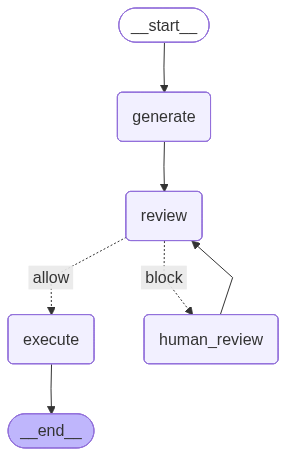

In [2]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())